**Regression Case Study Project**

Cici Zhang

1/21/2026

# Part 1: Fuel Consumption -> Horsepower Prediction

**Dataset:**
[FuelEconomy.cvs](https://www.kaggle.com/datasets/ohiedulhaquemdasad/fuel-consumption-based-on-hp-linear-regression)


**Task:** Predict horsepower using regression

**Models:**
 - Linear Regression
 - Polynomial Regression (degree 2, 3, 4)

**Regularization:** Not used (as requested)

**Evaluation Metrics(Train&Test)**

For each model, we report:
- Mean Squared Error(MSE)
- Mean Absolute Error(MAE)
- Coefficient of Determination(R^2)

In [1]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split #split into train and test
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1) Load and inspect the dataset

In this section, we load the dataset into a pandas DataFrame and perform a **basic sanity check** before building any models.

### What this code does
- **Loads the CSV file** into a pandas DataFrame (`df`)
- Prints the **shape** of the dataset:
  - number of rows = number of samples (vehicles)
  - number of columns = number of features (variables - HP and Fuel Economy)
- Prints the **column names** to understand what information is available

- Shows **summary statistics** using `describe()`:
  - in this case, mean, standard deviation, min/max, quartiles, etc.
- Checks for **missing values** in each column

### Why this matters
Machine learning models depend heavily on clean and well-structured data.  
Before training any regression model, we must confirm:
- the target column exists (here: **Horse power**)
- columns have reasonable values and types
- there are no unexpected missing values that could break model training
- since no missing values were present in this case, no data cleaning or imputation was required.

In [2]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "/content/drive/MyDrive/EE344/FuelEconomy.csv"
df = pd.read_csv(DATA_PATH)

print("\nColumns:")
print(df.columns.tolist())
print("Shape:", df.shape)

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Columns:
['Horse Power', 'Fuel Economy (MPG)']
Shape: (100, 2)

Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


,0
Horse Power,0
Fuel Economy (MPG),0


## 2) Train/Test split

In below, we will split the dataset into 70% training and 30% testing.
We also need to fix the value of random_state, which ensures reprofucibility by making random operations deterministic, so results remain consistent across runs.

#### What each function does

- **`prepare_xy(df_in)`**  
  Removes rows with missing values and splits the dataset into:
  - **X** = input features (all columns except the target)  
  - **y** = target variable (here: `Performance Index`)

- **`split_data(X, y)`**  
  Performs a **70% / 30% train-test split** using a fixed `random_state` so that results are reproducible.



In [6]:
# ============================================================
# Tarin/Test split
# ============================================================

TARGET_COL = "Horse Power"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean[["Fuel Economy (MPG)"]]
    y = df_clean[target_col]
    return X, y
def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


### 3) Model training:  Linear + Polynomial regression

In below, we will run multiple regression experiments.

To keep our notebook clean and avoid copy-pasting the same code many times, we define a few helper functions.

These functions handle the most common steps in any supervised learning workflow:

1. Training linear and polynomial regression models
2. Computing evaluation metrics
3. Visualizing predicted vs actual values on the test set
4. Printing a simplified version of the learned regression equation

#### What each function does


- **`compute_metrics(y_true, y_pred)`**  
  Computes three standard regression evaluation metrics:
  - **MSE (Mean Squared Error):** penalizes large errors more strongly  
  - **MAE (Mean Absolute Error):** average absolute prediction error  
  - **R² (Coefficient of Determination):** measures how well the model explains the variance in the data

- **`print_fitted_equation(...)`**  
  Prints the fitted regression model equation using the learned coefficients.  
  For polynomial regression, the number of terms can become very large, so the notebook prints only the **top terms** with the largest coefficient magnitude.

- **`plot_actual_vs_predicted_test(...)`**  
  Creates a scatter plot for the **test set** showing:
  - **Actual values** (blue circles)
  - **Predicted values** (red x’s)  
  This helps visually compare how close the predictions are to real values.

- **`run_models_and_evaluate(...)`**  
  This is the main driver function that runs everything for a given scenario:
  - Trains **Linear Regression** and **Polynomial Regression (degrees 2, 3, 4)**
  - Evaluates **train and test** performance using MSE, MAE, and R²
  - Prints fitted equation (top terms)
  - Generates test-set scatter plots
  - Returns a clean results table for easy comparison


Then, I will tain the following models to predict HP:

- a) Linear Regression

- b) Polynomial Regression (degree 2)

- c) Polynomial Regression (degree 3)

- d) Polynomial Regression (degree 4)

#### What we are testing here
We want to answer the question:

✅ **Can we predict the vehicle's fuel economy (MPG) from the vehicle's horse poower?**

#### What the code does
- Trains and evaluates the models above using a **70% / 30% random train-test split**
- Prints the fitted model equation (top coefficient terms)

In [7]:
def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    print(X.shape, y.shape)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)
    print(X_train.shape, y_train.shape)
    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)

(100, 1) (100,)
(70, 1) (70,)

Scenario: A
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)


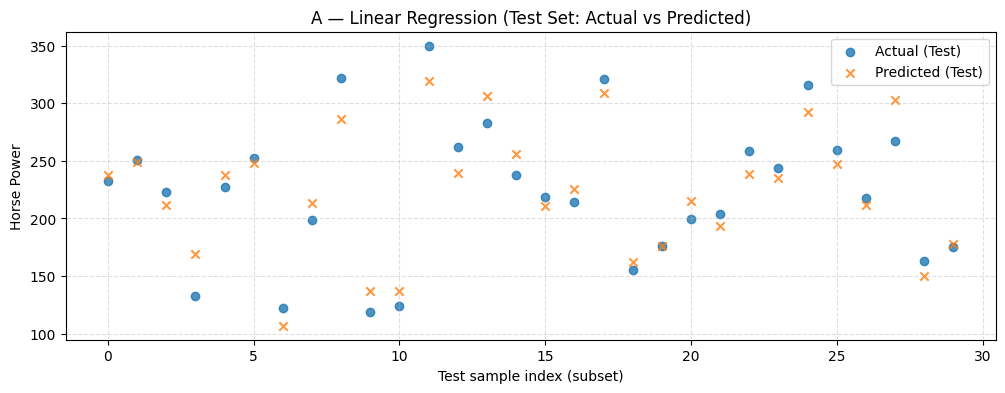


Scenario: A
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2


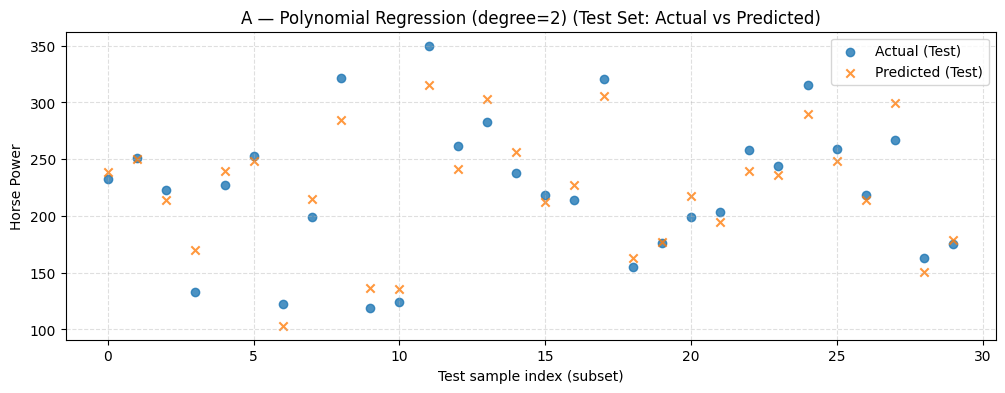


Scenario: A
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3


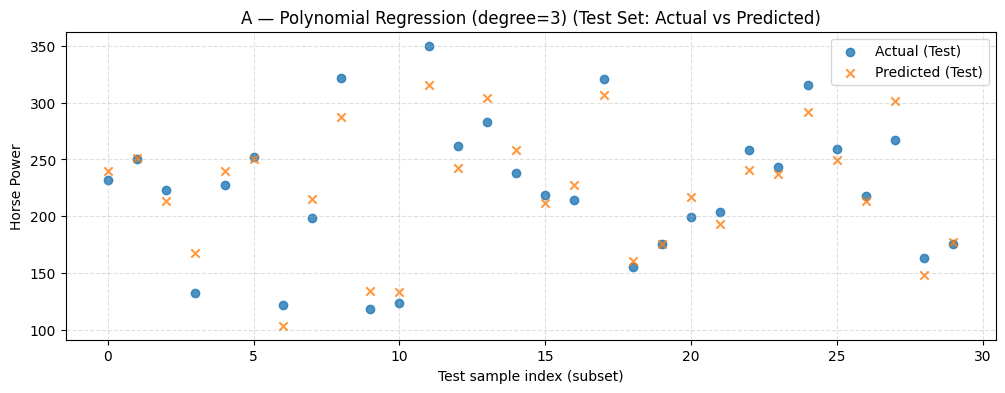


Scenario: A
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4


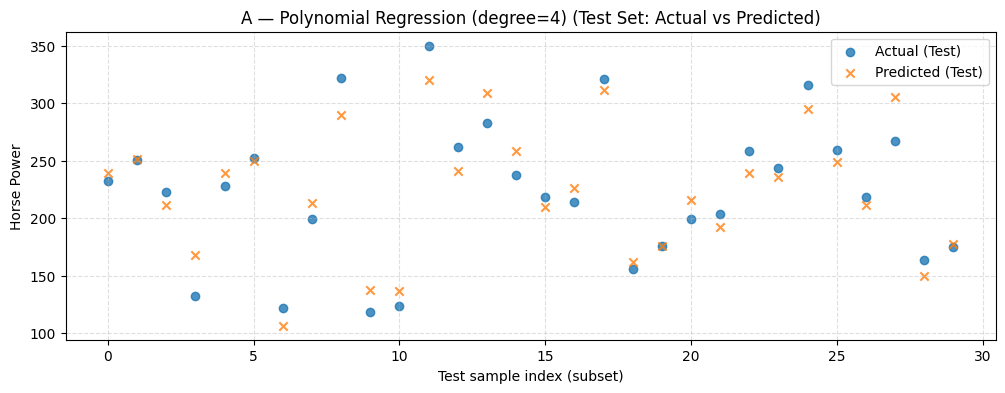

In [13]:
results_A = run_models_and_evaluate(
    df,
    scenario_name="A",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True
)


## 4) Model evaluation(train and test)

#### What the code does

- Reports **Train and Test** metrics:
  - **MSE**, **MAE**, and **R²**


In [11]:
display(results_A)

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,A,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,A,Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,A,Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,A,Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


## 5) Discussion and interpretation

5.1 According to the result, the polynomial regression(degree=4) gives the best performance because among all, it has the lowest Test MSE and Test MAE, and Test R^2 closest to 1 with corresponding values 313.798757, 14.735471, 0.913868.

5.2 Increasing polynomial degree does not always improve performance. The purpose of testing multiple polynomial degrees is to find the best one. Comparing polynomial degree=2 and linear regression, linear regression gives a better performance because it has a lower Test MSE and Test MAE, and Test R^2 is closer to 1. This gives a contradiction to the argument that increasing polynomial degree always improve performance.

5.3 Everything performs normally, and the performance of test results are even better than the training ones. So we can say this model training is a success.

# Part 2: Weather -> Daily Electricity Consumption Prediction

**Dataset:**
[Electricity Consumption Based On Weather Data.cvs](https://www.kaggle.com/datasets/sudhirsingh27/electricity-consumption-based-on-weather-data)


**Task:** Build regression models to predict daily electricity consumption using weather features.

**Models:**
 - Linear Regression
 - Polynomial Regression (degree 2, 3, 4)

**Regularization:** Not used (as requested)

## 1) Load and inspect the dataset

In this section, we load the dataset into a pandas DataFrame and perform a **basic sanity check** before building any models.

The file contains the following features:
- date: Date of observation
- AWND: Average daily wind speed(m/s)
- PRCP: Daily precipitation(mm)
- TMAX: Daily maximum temperature(°C)
- TMIN: Daily minimum temperature(°C)
- daily_consumption: Total daily electricity consumption

#### What this code does
- **Loads the CSV file** into a pandas DataFrame (`df`)
- Prints the **shape** of the dataset:
  - number of rows = number of samples
  - number of columns = number of features (variables - listed above)
- Prints the **column names** to understand what information is available

- Shows **summary statistics** using `describe()`:
  - for numeric columns: mean, standard deviation, min/max, quartiles, etc.
  - for non-numeric columns: count, unique values, most common value, etc.
- Checks for **missing values** in each column

### Why this matters
Machine learning models depend heavily on clean and well-structured data.  
Before training any regression model, we must confirm:
- the target column exists (here: **daily consumption**)
- columns have reasonable values and types
- there are no unexpected missing values that could break model training
- since no missing values were present in this case, no data cleaning or imputation was required.

In [15]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "/content/drive/MyDrive/EE344/electricity_consumption_based_weather_dataset.csv"
df = pd.read_csv(DATA_PATH)

print("\nColumns:")
print(df.columns.tolist())
print("Shape:", df.shape)

print("\nSummary statistics:")
display(df.describe(include="all"))
print("\nDependent variable")
display(df['daily_consumption'])
print("\nMissing values per column:")
display(df.isna().sum())


Columns:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']
Shape: (1433, 6)

Summary statistics:


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Dependent variable


,daily_consumption
0,1209.176
1,3390.460
2,2203.826
3,1666.194
4,2225.748
...,...
1428,2041.536
1429,1577.536
1430,1796.248
1431,1431.164



Missing values per column:


,0
date,0
AWND,15
PRCP,0
TMAX,0
TMIN,0
daily_consumption,0


## 2) Train/Test split



In below, we will split the dataset into 70% training and 30% testing.
We also need to fix the value of random_state, which ensures reprofucibility by making random operations deterministic, so results remain consistent across runs.

#### What each function does

- **`prepare_xy(df_in)`**  
  Removes rows with missing values and splits the dataset into:
  - **X** = input features (all columns except the target)  
  - **y** = target variable (here: `daily_consumption`)

- **`split_data(X, y)`**  
  Performs a **70% / 30% train-test split** using a fixed `random_state` so that results are reproducible.



In [16]:
# ============================================================
# Tarin/Test split
# ============================================================

TARGET_COL = "daily_consumption"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y
def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


## 3) Model training


In below, we will run multiple regression experiments.

To keep our notebook clean and avoid copy-pasting the same code many times, we define a few helper functions.

These functions handle the most common steps in any supervised learning workflow:

1. Training linear and polynomial regression models
2. Computing evaluation metrics
3. Visualizing predicted vs actual values on the test set
4. Printing a simplified version of the learned regression equation

#### What each function does


- **`compute_metrics(y_true, y_pred)`**  
  Computes three standard regression evaluation metrics:
  - **MSE (Mean Squared Error):** penalizes large errors more strongly  
  - **MAE (Mean Absolute Error):** average absolute prediction error  
  - **R² (Coefficient of Determination):** measures how well the model explains the variance in the data

- **`print_fitted_equation(...)`**  
  Prints the fitted regression model equation using the learned coefficients.  
  For polynomial regression, the number of terms can become very large, so the notebook prints only the **top terms** with the largest coefficient magnitude.

- **`plot_actual_vs_predicted_test(...)`**  
  Creates a scatter plot for the **test set** showing:
  - **Actual values** (blue circles)
  - **Predicted values** (red x’s)  
  This helps visually compare how close the predictions are to real values.

- **`run_models_and_evaluate(...)`**  
  This is the main driver function that runs everything for a given scenario:
  - Trains **Linear Regression** and **Polynomial Regression (degrees 2, 3, 4)**
  - Evaluates **train and test** performance using MSE, MAE, and R²
  - Prints fitted equation (top terms)
  - Generates test-set scatter plots
  - Returns a clean results table for easy comparison


Then, I will tain the following models to predict HP:

- a) Linear Regression

- b) Polynomial Regression (degree 2)

- c) Polynomial Regression (degree 3)

- d) Polynomial Regression (degree 4)

#### What we are testing here
We want to answer the question:

✅ **Can we predict the daily consumption from all these weather features?**

#### What the code does
- Trains and evaluates the models above using a **70% / 30% random train-test split**
- Prints the fitted model equation (top coefficient terms)

In [17]:
def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    print(X.shape, y.shape)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)
    print(X_train.shape, y_train.shape)
    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)

(1418, 4) (1418,)
(992, 4) (992,)

Scenario: A
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


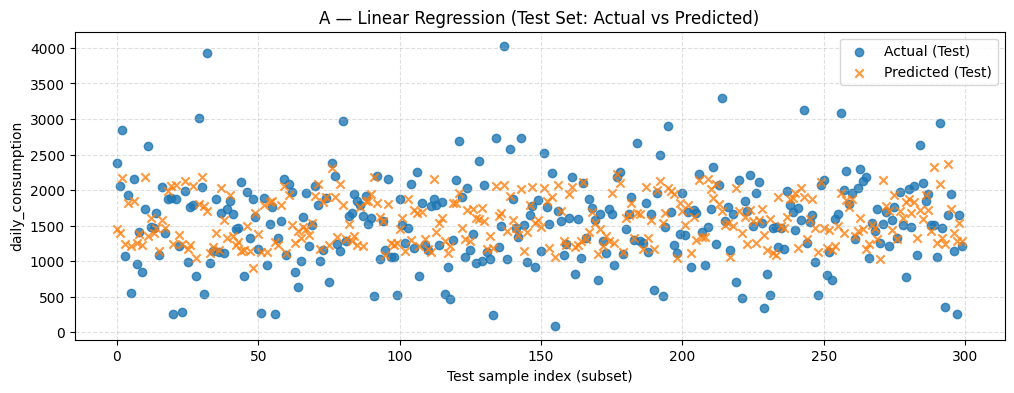


Scenario: A
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


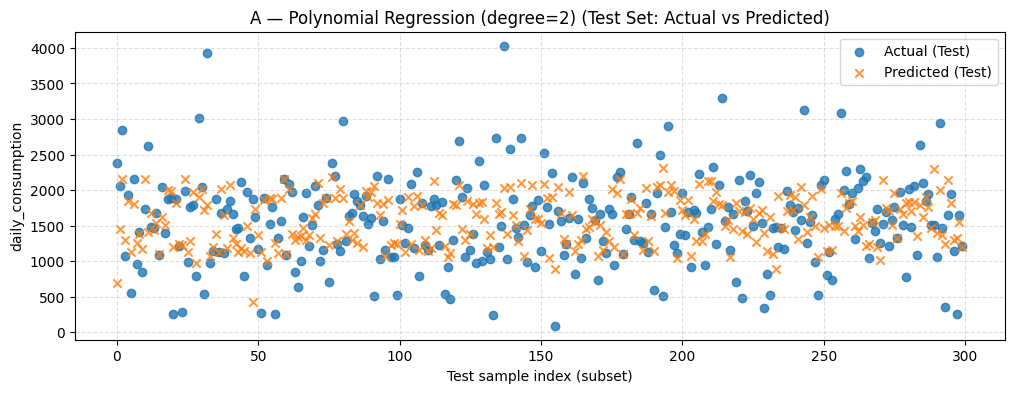


Scenario: A
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


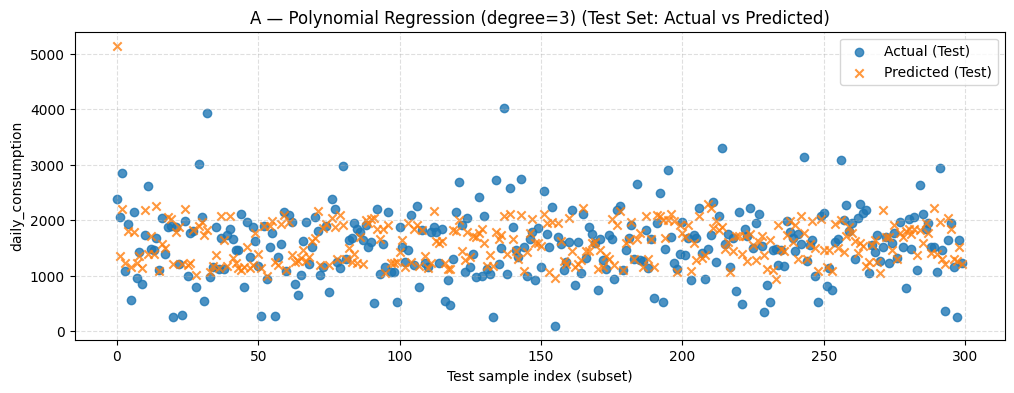


Scenario: A
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


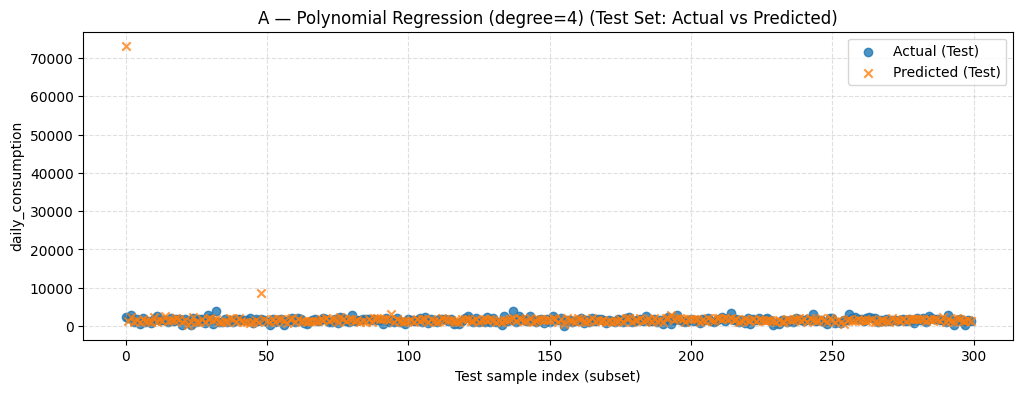

In [21]:
df_no_extra = df.drop(columns=["date"]).copy()
results_A = run_models_and_evaluate(
    df_no_extra,
    scenario_name="A",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

## 4) Model evaluation

#### What the code does

- Reports **Train and Test** metrics:
  - **MSE**, **MAE**, and **R²**


In [22]:
display(results_A)

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,A,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,A,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,A,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,A,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


## 5) Discussion and Interpretation

5.1 The linear regression fits the best because it has the best test performance, with the lowest MSE and MAE among all, and a R^2 value closest to 1. This tells us that the relationship between weather and electricity usage is more likely to have a linear relationship.

But clearly, none of the models performed well, based on the fact that the R^2 value closest to 1 is 0.299(in linear regression).


5.2 According to the test result for all 4 of them, linear regression provides the best result, which gives a contradiction.

5.3 From the metrics, as the degree goes higher, the train error decreases but test error increases. This is due to overfitting, especially for 4th degree models.

In our 4th degree model, the Train MAE(372.116566) is lower than the linear model, but the Test MAE(578.642201) is significantly higher. At the same time, the Test R^2 is -33.313844, which is very off. The gap happends when the model is no longer learning the underlying patterning, it just memorizes the noise and specfic outliers in the training set. So when the model meets new data, it failed.

5.4 None of the modules achieve good test performance. I think the main reasons should be:
- Limited feature set: We are only looking at weather, but electricity consumption is heavily driven by non-weather factors. For example, holidays, building occupancy, etc.  
- High noise: At x=0, there's a dependent varibale with a high residual. So in the data collection process, outliers or errors are definitely exist. High-noise data makes it difficult to find the best fit line, and the MSE, MAE, R^2 will be high too.